##### Use Run All option in Jupyter Notebook

##### The `x_training_scaled` values can be alternated between 300 and 900 nautical miles

In [41]:
# Uncomment the following lines to install the required packages

# pip install dymos
# pip install -U matplotlib
# conda install -c conda-forge pyoptsparse
# pip install pandas
# pip install bokeh

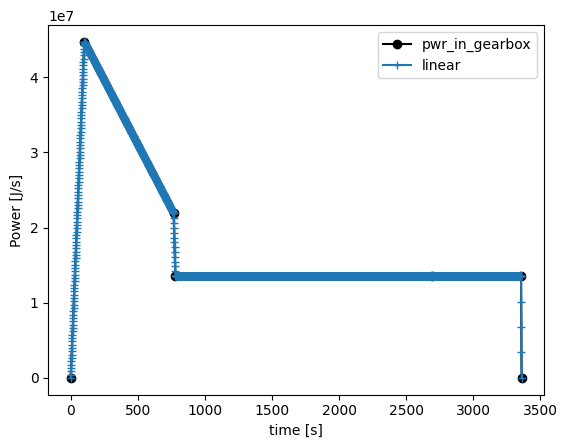

In [42]:
import numpy as np
from openmdao.components.interp_util.interp import InterpND

import matplotlib.pyplot as plt

pwr_in_gearbox = np.array([0.0, 44693976.3, 21876560.9, 13546016.7, 13546016.7, 13546016.7, 0.0])

# 300 NM
x_training_scaled = np.array([0, 101, 767, 780, 2690, 3356, 3360])
# 900 NM
# x_training_scaled = np.array([0, 101, 767, 780, 6534, 7201, 7260])


# Training interp with time (in [s]) and power (in [J/s])
interp_linear = InterpND(method='slinear', points=x_training_scaled, values=pwr_in_gearbox)

# Creating range for time corresponding to power in J/s
x_range = np.linspace(0.0, x_training_scaled[-1], x_training_scaled[-1] + 1)
# x_range should be all in 1 [s] like 0, 1, 2, 3, 4, ...
# print(x_range)

y_range_linear = interp_linear.interpolate(x_range)

plt.plot(x_training_scaled, pwr_in_gearbox, marker = 'o', color='black', label='pwr_in_gearbox')
plt.plot(x_range, y_range_linear, marker = '+', label='linear')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Power [J/s]')
plt.show()
np.set_printoptions(threshold=100000)

In [43]:
np.savetxt("power-values.csv", y_range_linear, delimiter=",", fmt='%.4f')
np.savetxt("time-points.csv", x_range, delimiter=",", fmt='%.4f')

In [44]:
import openmdao.api as om
import dymos as dm
import matplotlib.pyplot as plt
import numpy as np

from FCBatSysODE import FCBatSysODEGroup

def kWh_to_J(kWh):
    return kWh * 1000 * 3600

pwr_in_gearbox = np.loadtxt("power-values.csv", delimiter=",", dtype=float)
time_points = np.loadtxt("time-points.csv", delimiter=",", dtype=float)

# Decide the number of segments (as an integer) of the problem based on total time steps
num_segments = np.round(pwr_in_gearbox.size/(4*1000)) * 100 # Replace 2 with 4 for 900 NM
num_segments = num_segments.astype(int)
num_segments_np = np.int64(num_segments)
num_segments = int(num_segments_np)

# Define the OpenMDAO problem and the problem has a model group within it.
prob = om.Problem(model=om.Group())

# Add a transcription to the problem
transcription0 = dm.GaussLobatto(num_segments=num_segments, order=3, compressed=True)

# Add a trajectory to the problem
traj = dm.Trajectory()
prob.model.add_subsystem('traj', traj)

# Define a Dymos Phase object with GaussLobatto Transcription
phase = dm.Phase(ode_class=FCBatSysODEGroup, transcription=transcription0)

# Add a phase to the trajectory
traj.add_phase(name='phase0', phase=phase)

# Set the time options and project the time onto the phase
phase.set_time_options(fix_initial=True, fix_duration=True, time_phase_targets=['time_phase'])

### States ###
phase.add_state('SoC', opt=True, fix_initial=True, fix_final=False, final_bounds=(0.3, 0.8), units=None, rate_source='dXdt:SoC', defect_scaler=1e-10)
# Gauss-lobatto required path constrain
phase.add_path_constraint('SoC', lower=0.3, upper=0.8)

phase.add_state('mass_fuel', opt=True, fix_initial=False, initial_bounds=(5, 10000), fix_final=True, units=None, rate_source='dXdt:mass_fuel', scaler=1e-4, defect_scaler=1e-15)
# Gauss-lobatto required path constrain
phase.add_path_constraint('mass_fuel', lower=0.0, upper=10000.0, scaler=1e-4)

### Dynamic Controls ###
phase.add_control(name='nminus1_active_fcsysmodules', targets=['nminus1_active_fcsysmodules'], opt=True, lower=0, upper=np.round(max(pwr_in_gearbox)/110000), continuity=False, rate_continuity=False, rate2_continuity=False, scaler=1e-3)

phase.add_control(name='current_nminus1fcstack', targets=['current_nminus1fcstack'], opt=True, lower=50, upper=642, continuity=False, rate_continuity=False, rate2_continuity=False, scaler=1e-3)

phase.add_control(name='current_nthfcstack', targets=['current_nthfcstack'], opt=True, lower=0, upper=642, continuity=False, rate_continuity=False, rate2_continuity=False, scaler=1e-3)

phase.add_control(name='C_rate', targets=['C_rate'], opt=True, lower=-1.0, upper=2.5, continuity=False, rate_continuity=False, rate2_continuity=False, scaler=1e-1, adder=1)

### Static Controls ###
split_ratio_default = 0.5
phase.add_parameter('split_ratio', targets=['split_ratio'], opt=True, val=split_ratio_default, lower=0, upper=1, static_target=False)

egy_batsys_default = 1000 # kWh
phase.add_parameter('egy_batsys', targets=['egy_batsys'], opt=True, val=kWh_to_J(egy_batsys_default), lower=kWh_to_J(0.001), upper=kWh_to_J(5000*4*5), static_target=False, scaler=1e-10)

### Fixed Static Controls ###
current_maxfcstack_default = 642.0 #A
phase.add_parameter('current_maxfcstack', targets=['current_maxfcstack'], opt=False, val=current_maxfcstack_default, static_target=False)

### Static Controls to be set by the user ###
grav_eff_h2_default = 0.45 #%
phase.add_parameter('grav_eff_h2', targets=['grav_eff_h2'], opt=False, val=grav_eff_h2_default, lower=0.01, upper=0.45, static_target=False)

pwr_dens_fcstack_default = 4 #kW/kg
phase.add_parameter('pwr_dens_fcstack', targets=['pwr_dens_fcstack'], opt=False, val=pwr_dens_fcstack_default, lower=0.01, upper=4, static_target=False)

egy_dens_batsys_default = 2.5 # kWh/kg
phase.add_parameter('egy_dens_batsys', targets=['egy_dens_batsys'], opt=False, val=egy_dens_batsys_default, lower=0.25, upper=2.5, static_target=False)

prob.model.linear_solver =  om.DirectSolver()

# Add Objective
phase.add_objective('tot_takeoff_mass', loc='initial', scaler=1e-5)

# Add a driver
prob.driver = driver =  om.pyOptSparseDriver()
prob.driver.options['optimizer'] = 'IPOPT'
prob.driver.opt_settings['mu_strategy'] = 'adaptive'
prob.driver.opt_settings['bound_mult_init_method'] = 'mu-based'
prob.driver.opt_settings['mu_init'] = 0.01 # 1e-1
prob.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'

# Add a driver case recorder to monitor all values of all variables over all time steps and function evaluations.
driver.recording_options['includes'] = ['*']
driver.recording_options['record_objectives'] = True
driver.recording_options['record_constraints'] = True
driver.recording_options['record_desvars'] = True
driver.recording_options['record_inputs'] = True
driver.recording_options['record_outputs'] = True
driver.recording_options['record_residuals'] = True
driver.add_recorder(om.SqliteRecorder("driver_cases.sql"))

# Enable Sparsity Pattern detection
prob.driver.declare_coloring()

# Save all data to another output file which plots these variables
phase.add_timeseries_output('n_fcsysmodules', units=None, shape=(1,))
phase.add_timeseries_output('dXdt:mass_fuel', units=None, shape=(1,))
phase.add_timeseries_output('dXdt:SoC', units=None, shape=(1,))
phase.add_timeseries_output('con_fcbatsys_1', units=None, shape=(1,))
phase.add_timeseries_output('con_fcsys_2', units=None, shape=(1,))
phase.add_timeseries_output('con_fcsys_3', units=None, shape=(1,))
phase.add_timeseries_output('pwr_el_inout_batsys', units=None, shape=(1,))
phase.add_timeseries_output('pwr_el_del_per_maxfcsysmodule', units=None, shape=(1,))
phase.add_timeseries_output('pwr_el_del_fcsys', units=None, shape=(1,))
phase.add_timeseries_output('pwr_el_max_fcsys', units=None, shape=(1,))

# Setup the problem
prob.setup(check=True)

# //BUG: Enable PowerInterpolation Comp and Total mass take off Exec Comp.
# Setup time constraints
prob['traj.phase0.t_initial'] = 0.0
prob['traj.phase0.t_duration'] = time_points[-1]

# Initial values
prob['traj.phase0.states:mass_fuel'] = phase.interp('mass_fuel', [2500, 0])
prob['traj.phase0.states:SoC'] = phase.interp('SoC', [0.8, 0.3])

prob['traj.phase0.controls:nminus1_active_fcsysmodules'][:] = 200
prob['traj.phase0.controls:current_nminus1fcstack'][:] = 321
prob['traj.phase0.controls:current_nthfcstack'][:] = 321
prob['traj.phase0.controls:C_rate'][:] = 0.5

#prob.run_model() #for checking
# check derivatives of all obj+constraints w.r.t all design variables
#prob.check_totals(compact_print=True)
 
prob.set_solver_print(level=0) #off for checking

# prob.model.list_inputs(units=True, shape=True)
# prob.model.list_outputs(units=True, shape=True)

dm.run_problem(prob, run_driver=True, simulate=True, make_plots=True)  #all false for checking

C:\Users\Sushil Pandey\AppData\Roaming\Python\Python312\site-packages\dymos\phase\phase.py:2354: RuntimeWarning: Invalid options for non-optimal parameter 'grav_eff_h2' in phase 'phase0': lower, upper
  warnings.warn(f"Invalid options for non-optimal parameter '{name}' in "
C:\Users\Sushil Pandey\AppData\Roaming\Python\Python312\site-packages\dymos\phase\phase.py:2354: RuntimeWarning: Invalid options for non-optimal parameter 'pwr_dens_fcstack' in phase 'phase0': lower, upper
  warnings.warn(f"Invalid options for non-optimal parameter '{name}' in "
C:\Users\Sushil Pandey\AppData\Roaming\Python\Python312\site-packages\dymos\phase\phase.py:2354: RuntimeWarning: Invalid options for non-optimal parameter 'egy_dens_batsys' in phase 'phase0': lower, upper
  warnings.warn(f"Invalid options for non-optimal parameter '{name}' in "
C:\Users\Sushil Pandey\AppData\Roaming\Python\Python312\site-packages\openmdao\core\group.py:2840: UnitsWarning:'traj.phases.phase0' <class Phase>: Output 'traj.phase


--- Constraint Report [traj] ---
    --- phase0 ---
        [path]    3.0000e-01 <= SoC <= 8.0000e-01  [None]
        [path]    0.0000e+00 <= mass_fuel <= 1.0000e+04  [None]

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


C:\Users\Sushil Pandey\AppData\Roaming\Python\Python312\site-packages\openmdao\recorders\sqlite_recorder.py:226: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Model viewer data has already been recorded for Driver.
Model viewer data has already been recorded for Driver.
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Model viewer data has already been recorded for Driver.
Model viewer data has already been recorded for Driver.
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Full total jacobian for problem 'problem16' was computed 3 times, taking 11.683841200079769 seconds.
Total jacobian shape: (1701, 1006) 


Jacobian shape: (1701, 1006)  (1.55% nonzero)
FWD solves: 28   REV solves: 0
Total colors vs. total size: 28 vs 1006  (97.22% improvement)

Sparsity computed usi

C:\Users\Sushil Pandey\AppData\Roaming\Python\Python312\site-packages\openmdao\core\total_jac.py:1646: DerivativesWarning:Constraints or objectives [('traj.phases.phase0->path_constraint->SoC', inds=[(0, 0)]), ('traj.phases.phase0->path_constraint->mass_fuel', inds=[(299, 0)])] cannot be impacted by the design variables of the problem.




Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   18.9886
       User Objective Time :       2.3876
       User Sensitivity Time :    15.6767
       Interface Time :            0.4898
       Opt Solver Time:            0.4345
    Calls to Objective Function :      26
    Calls to Sens Function :           26


   Objectives
      Index  Name                                             Value
          0  traj.phase0.rhs_disc.tot_takeoff_mass     4.161655E-02

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name                                                   Type      Lower Bound            Value      Upper Bound     Status
          0  traj.phase0.parameters:split_ratio_0                      c     0.000000E+00     9.980176E-01     1.000000E+00           
          1  traj.phase0.parameters:eg

C:\Users\Sushil Pandey\AppData\Roaming\Python\Python312\site-packages\openmdao\core\group.py:1101: DerivativesWarning:Constraints or objectives [ode_eval.control_interp.control_rates:C_rate_rate2, ode_eval.control_interp.control_rates:current_nminus1fcstack_rate2, ode_eval.control_interp.control_rates:current_nthfcstack_rate2, ode_eval.control_interp.control_rates:nminus1_active_fcsysmodules_rate2] cannot be impacted by the design variables of the problem because no partials were defined for them in their parent component(s).
C:\Users\Sushil Pandey\AppData\Roaming\Python\Python312\site-packages\openmdao\recorders\sqlite_recorder.py:226: UserWarning:The existing case recorder file, dymos_simulation.db, is being overwritten.


INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings

Simulating trajectory traj
Model viewer data has already been recorded for Driver.
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Done simulating trajectory traj


Problem: problem16
Driver:  pyOptSparseDriver
  success     : True
  iterations  : 27
  runtime     : 3.6659E+01 s
  model_evals : 27
  model_time  : 1.4705E-01 s
  deriv_evals : 26
  deriv_time  : 5.0249E+00 s
  exit_status : SUCCESS

In [45]:
import sqlite3
import pandas as pd

# Load the SQLite database
db_path = './driver_cases.sql'
conn = sqlite3.connect(db_path)

# List all tables in the SQLite database
try:
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql_query(query, conn)
    print("Tables in the database:")
    print(tables)
except Exception as e:
    print(f"An error occurred while listing tables: {e}")
finally:
    conn.close()

print('------------------')


import sqlite3
import pandas as pd

# Load the SQLite database
db_path = './driver_cases.sql'
conn = sqlite3.connect(db_path)

# Extract a small sample of data from the driver_iterations table
try:
    query = "SELECT * FROM driver_iterations LIMIT 5;"
    sample_data = pd.read_sql_query(query, conn)
    print("Sample data from 'driver_iterations' table:")
    print(sample_data)
except Exception as e:
    print(f"An error occurred while extracting sample data: {e}")
finally:
    conn.close()

Tables in the database:
                 name
0   global_iterations
1   driver_iterations
2  driver_derivatives
3       problem_cases
4   system_iterations
5   solver_iterations
6            metadata
7     driver_metadata
8     system_metadata
9     solver_metadata
------------------
Sample data from 'driver_iterations' table:
   id  counter       iteration_coordinate     timestamp  success msg  \
0   1        1  rank0:pyOptSparse_IPOPT|0  1.062267e+06        1       
1   2        2  rank0:pyOptSparse_IPOPT|1  1.062278e+06        1       
2   3        3  rank0:pyOptSparse_IPOPT|2  1.062279e+06        1       
3   4        4  rank0:pyOptSparse_IPOPT|3  1.062279e+06        1       
4   5        5  rank0:pyOptSparse_IPOPT|4  1.062279e+06        1       

                                              inputs  \
0  {"traj.phases.phase0.collocation_constraint.dt...   
1  {"traj.phases.phase0.collocation_constraint.dt...   
2  {"traj.phases.phase0.collocation_constraint.dt...   
3  {"traj.phas

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


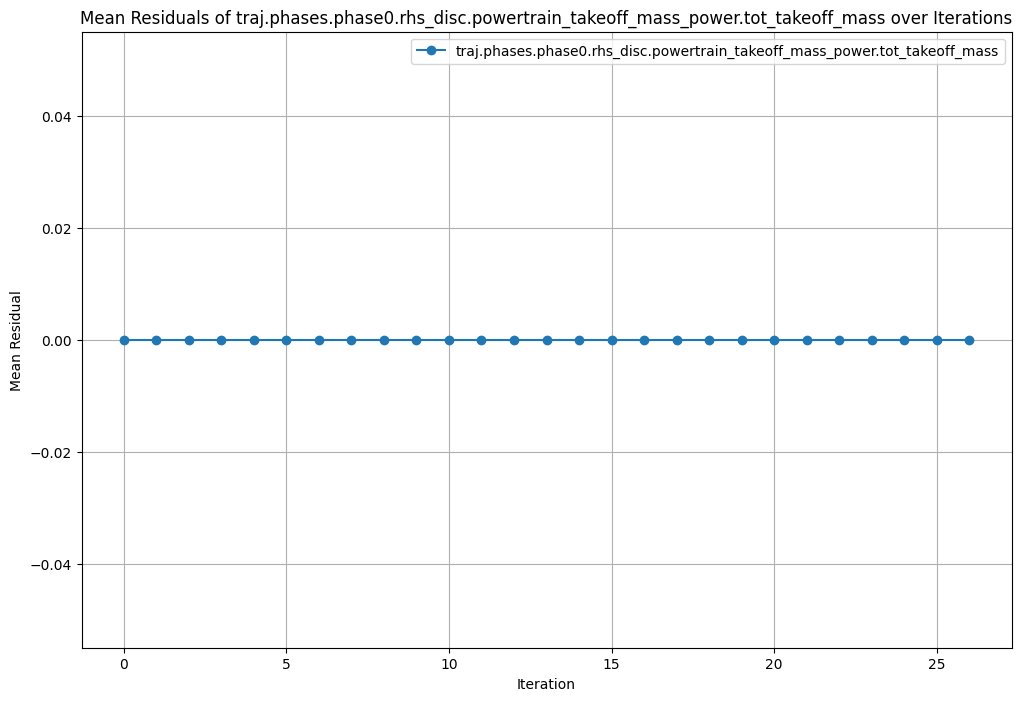

In [46]:
import sqlite3
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the SQLite database
db_path = './driver_cases.sql'
conn = sqlite3.connect(db_path)

# Load data from the driver_iterations table
try:
    query = "SELECT * FROM driver_iterations;"
    driver_iterations_data = pd.read_sql_query(query, conn)

    # Extract residuals
    def extract_residuals(residuals_str):
        try:
            return json.loads(residuals_str)
        except json.JSONDecodeError:
            return None

    driver_iterations_data['residuals'] = driver_iterations_data['residuals'].apply(extract_residuals)

    # Drop rows where residuals is None
    residuals_data = driver_iterations_data.dropna(subset=['residuals'])

    # Extract and plot a specific residual
    selected_residual_key = 'traj.phases.phase0.rhs_disc.powertrain_takeoff_mass_power.tot_takeoff_mass'

    # Create a dataframe to store mean residuals per iteration
    mean_residuals_per_iteration = []

    for i, row in residuals_data.iterrows():
        residuals_dict = row['residuals']
        if selected_residual_key in residuals_dict:
            residual_values = residuals_dict[selected_residual_key]
            mean_residual = sum(residual_values) / len(residual_values)
            mean_residuals_per_iteration.append((i, mean_residual))

    # Convert to DataFrame for easier plotting
    mean_residuals_df = pd.DataFrame(mean_residuals_per_iteration, columns=['Iteration', 'Mean Residual'])

    # Plot mean residuals
    plt.figure(figsize=(12, 8))
    plt.plot(mean_residuals_df['Iteration'], mean_residuals_df['Mean Residual'], marker='o', label=selected_residual_key)

    plt.xlabel('Iteration')
    plt.ylabel('Mean Residual')
    plt.title(f'Mean Residuals of {selected_residual_key} over Iterations')
    plt.legend()
    plt.grid(True)
    plt.savefig('dymos_driver_mass_residual.eps', format='eps', dpi=600)
    plt.savefig('dymos_driver_mass_residual.pdf', format='pdf', dpi=600)
    plt.show()


except Exception as e:
    print(f"An error occurred while extracting and plotting residuals: {e}")
finally:
    conn.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


6744.965346587297
6744.965346587297
5586.415205594704
5497.760269824748
4927.887338064302
4613.006977154237
4598.849743286725
4384.680275850556
4293.604008884007
4298.754805031147
4300.950717300122
4308.865065765415
4310.334902547593
4267.696301204841
4200.474372167964
4196.873324166465
4172.4953656455755
4166.070111266953
4162.84522559606
4162.115304465862
4161.854393288601
4162.142470523765
4162.169098514868
4161.709315943182
4161.678795716997
4161.654693758459
4161.654693758459


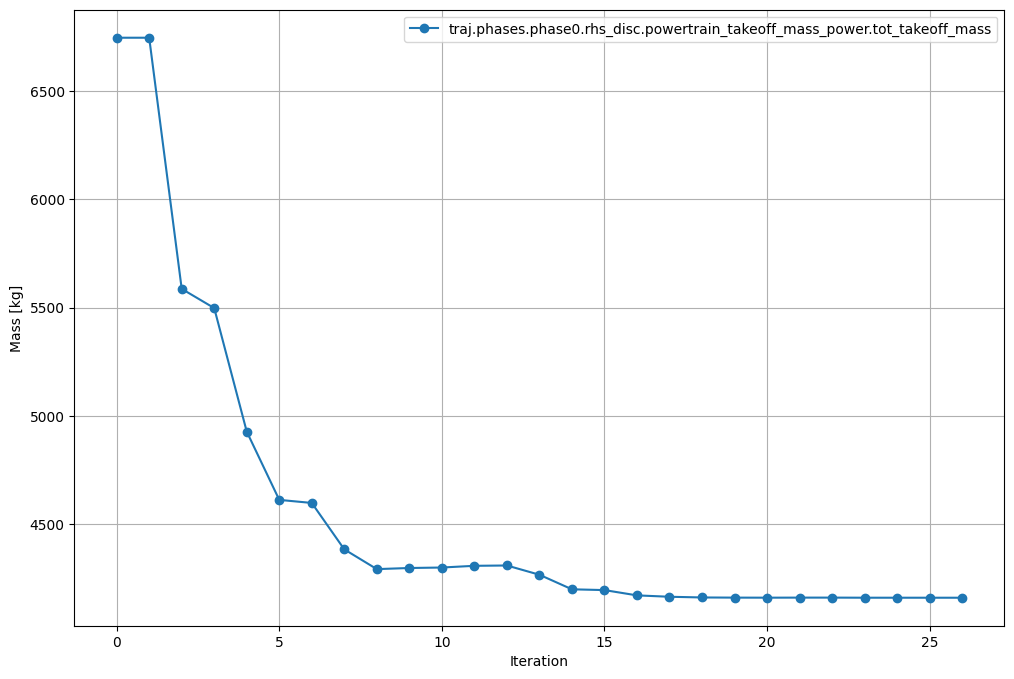

In [47]:
import sqlite3
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the SQLite database
db_path = './driver_cases.sql'
conn = sqlite3.connect(db_path)

# Load data from the driver_iterations table
try:
    query = "SELECT * FROM driver_iterations;"
    driver_iterations_data = pd.read_sql_query(query, conn)

    # Extract outputs
    def extract_outputs(outputs_str):
        try:
            return json.loads(outputs_str)
        except json.JSONDecodeError:
            return None

    driver_iterations_data['outputs'] = driver_iterations_data['outputs'].apply(extract_outputs)

    # Drop rows where outputs is None
    outputs_data = driver_iterations_data.dropna(subset=['outputs'])

    # Extract and plot specific outputs
    selected_output_keys = [
        'traj.phases.phase0.rhs_disc.powertrain_takeoff_mass_power.tot_takeoff_mass',
        # 'traj.phases.phase0.rhs_col.powertrain_takeoff_mass_power.tot_takeoff_mass'
    ]

    plt.figure(figsize=(12, 8))

    for selected_output_key in selected_output_keys:
        values_per_iteration = []

        for i, row in outputs_data.iterrows():
            outputs_dict = row['outputs']
            if selected_output_key in outputs_dict:
                output_values = outputs_dict[selected_output_key]
                # mean_output = sum(output_values) / len(output_values) if isinstance(output_values, list) else output_values
                mean_output = output_values[0]
                print(mean_output)
                values_per_iteration.append((i, mean_output))

        # Convert to DataFrame for easier plotting
        values_df = pd.DataFrame(values_per_iteration, columns=['Iteration', 'Value'])

        # Plot values
        plt.plot(values_df['Iteration'], values_df['Value'], marker='o', label=selected_output_key)

    plt.xlabel('Iteration')
    plt.ylabel('Mass [kg]')
    # plt.title('Outputs over Iterations')
    plt.legend()
    plt.grid(True)
    plt.savefig('dymos_driver_mass.eps', format='eps', dpi=600)
    plt.savefig('dymos_driver_mass.pdf', format='pdf', dpi=600)
    plt.show()


except Exception as e:
    print(f"An error occurred while extracting and plotting outputs: {e}")
finally:
    conn.close()

In [48]:
import timeseries_plots

timeseries_plots.timeseries_plots('dymos_solution.db', simulation_record_file='dymos_simulation.db', plot_dir="plots")